<a href="https://colab.research.google.com/github/rashmidubey2410/Malaria-Parasite-Detection-Using-CNN-Model/blob/master/Malaria_Parasite_Detection_Using_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**RESERCH PAPER LINK**: 

https://pubmed.ncbi.nlm.nih.gov/31545747/

https://ieeexplore.ieee.org/document/7822567

https://lhncbc.nlm.nih.gov/publication/pub9932



**Reasearch paper Results:** A patient-level five-fold cross-evaluation demonstrates the effectiveness of the customized CNN model in discriminating between positive (parasitic) and negative image patches in terms of the following performance indicators: accuracy (93.46% ± 0.32%), AUC (98.39% ± 0.18%), sensitivity (92.59% ± 1.27%), specificity (94.33% ± 1.25%), precision (94.25% ± 1.13%), and negative predictive value (92.74% ± 1.09%). High correlation coefficients (>0.98) between automatically detected parasites and ground truth, on both image level and patient level, demonstrate the practicality of our method. 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.layers import Conv2D,MaxPool2D,ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Set up Kaggle**

In [3]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [4]:
import json

token = {"username":"rashmidubey2424","key":"1064f30b894e182aee70d6710a1d75a4"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [5]:
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


**Download and set up data**

In [6]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria -p /content

cell-images-for-detecting-malaria.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
import os
import zipfile

local_zip = '/content/cell-images-for-detecting-malaria.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/cell-images-for-detecting-malaria')
zip_ref.close()

In [8]:
# # Directory with our training unifected pictures
infected_dir = os.path.join('/content/cell-images-for-detecting-malaria/cell_images/Uninfected')# Directory with our training infected or parasitized pictures
uninfected_dir = os.path.join('/content/cell-images-for-detecting-malaria/cell_images/Parasitized')
print(len(os.listdir(infected_dir)))
print(len(os.listdir(uninfected_dir)))

13780
13780


Now we need to structure our data into folders. We want a training folder and a testing folder. And each of these will have a uninfected folder (containing uninfected cell images ) and infected folder(containing infected cell images).

In [9]:
try:
    os.mkdir('/content/cell-images-for-detecting-malaria/cell_images/training')
    os.mkdir('/content/cell-images-for-detecting-malaria/cell_images/testing')
    os.mkdir('/content/cell-images-for-detecting-malaria/cell_images/training/uninfected')
    os.mkdir('/content/cell-images-for-detecting-malaria/cell_images/training/infected')
    os.mkdir('/content/cell-images-for-detecting-malaria/cell_images/testing/uninfected')
    os.mkdir('/content/cell-images-for-detecting-malaria/cell_images/testing/infected')
except OSError as e:
    print('error:', e)

error: [Errno 17] File exists: '/content/cell-images-for-detecting-malaria/cell_images/training'


In [10]:
import random 
from shutil import copyfile

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


INFECTED_SOURCE_DIR = "/content/cell-images-for-detecting-malaria/cell_images/Parasitized/"
TRAINING_INFECTED_DIR = "/content/cell-images-for-detecting-malaria/cell_images/training/infected/"
TESTING_INFECTED_DIR = "/content/cell-images-for-detecting-malaria/cell_images/testing/infected/"
UNINFECTED_SOURCE_DIR = "/content/cell-images-for-detecting-malaria/cell_images/Uninfected/"
TRAINING_UNINFECTED_DIR = "/content/cell-images-for-detecting-malaria/cell_images/training/uninfected/"
TESTING_UNINFECTED_DIR = "/content/cell-images-for-detecting-malaria/cell_images/testing/uninfected/"

split_size = .9
split_data(INFECTED_SOURCE_DIR, TRAINING_INFECTED_DIR, TESTING_INFECTED_DIR, split_size)
split_data(UNINFECTED_SOURCE_DIR, TRAINING_UNINFECTED_DIR, TESTING_UNINFECTED_DIR, split_size)

In [11]:
train_infected_names = os.listdir(TRAINING_INFECTED_DIR)
print(train_infected_names[:10])
train_uninfected_names = os.listdir(TRAINING_UNINFECTED_DIR)
print(train_uninfected_names[:10])

['C182P143NThinF_IMG_20151201_171950_cell_199.png', 'C182P143NThinF_IMG_20151201_172216_cell_129.png', 'C119P80ThinF_IMG_20151002_122720_cell_166.png', 'C68P29N_ThinF_IMG_20150819_134112_cell_143.png', 'C129P90ThinF_IMG_20151004_134306_cell_149.png', 'C97P58ThinF_IMG_20150917_151437_cell_157.png', 'C180P141NThinF_IMG_20151201_165659_cell_21.png', 'C158P119ThinF_IMG_20151115_181035_cell_173.png', 'C129P90ThinF_IMG_20151004_134520_cell_117.png', 'C129P90ThinF_IMG_20151004_134700_cell_31.png']
['C156P117ThinF_IMG_20151115_155104_cell_104.png', 'C81P42ThinF_IMG_20150817_120712_cell_1.png', 'C103P64ThinF_IMG_20150918_164331_cell_72.png', 'C168P129ThinF_IMG_20151118_155802_cell_50.png', 'C65P26N_ThinF_IMG_20150818_154714_cell_120.png', 'C154P115ThinF_IMG_20151115_141407_cell_177.png', 'C129P90ThinF_IMG_20151004_133421_cell_87.png', 'C135P96ThinF_IMG_20151005_123715_cell_121.png', 'C6NThinF_IMG_20150609_122725_cell_89.png', 'C226ThinF_IMG_20151112_131731_cell_12.png']


In [12]:
#The same can be done for the test directory

test_infected_names = os.listdir(TESTING_INFECTED_DIR)
print(test_infected_names[:10])

test_uninfected_names = os.listdir(TESTING_UNINFECTED_DIR)
print(test_uninfected_names[:10])

['C129P90ThinF_IMG_20151004_134520_cell_117.png', 'C129P90ThinF_IMG_20151004_134700_cell_31.png', 'C59P20thinF_IMG_20150803_113139_cell_9.png', 'C133P94ThinF_IMG_20151004_155721_cell_110.png', 'C59P20thinF_IMG_20150803_115303_cell_36.png', 'C180P141NThinF_IMG_20151201_163702_cell_206.png', 'C149P110ThinF_IMG_20151115_114555_cell_305.png', 'C59P20thinF_IMG_20150803_115303_cell_3.png', 'C59P20thinF_IMG_20150803_112733_cell_208.png', 'C118P79ThinF_IMG_20151002_105827_cell_154.png']
['C156P117ThinF_IMG_20151115_155104_cell_104.png', 'C47P8thin_Original_Motic_IMG_20150714_093947_cell_91.png', 'C184P145ThinF_IMG_20151203_103637_cell_61.png', 'C189P150ThinF_IMG_20151203_141719_cell_11.png', 'C163P124ThinF_IMG_20151116_111925_cell_177.png', 'C227ThinF_IMG_20151112_135308_cell_100.png', 'C240ThinF_IMG_20151127_115247_cell_203.png', 'C206ThinF_IMG_20151029_140511_cell_54.png', 'C159P120ThinF_IMG_20151115_185541_cell_35.png', 'C74P35_ThinF_IMG_20150815_114153_cell_19.png']


In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

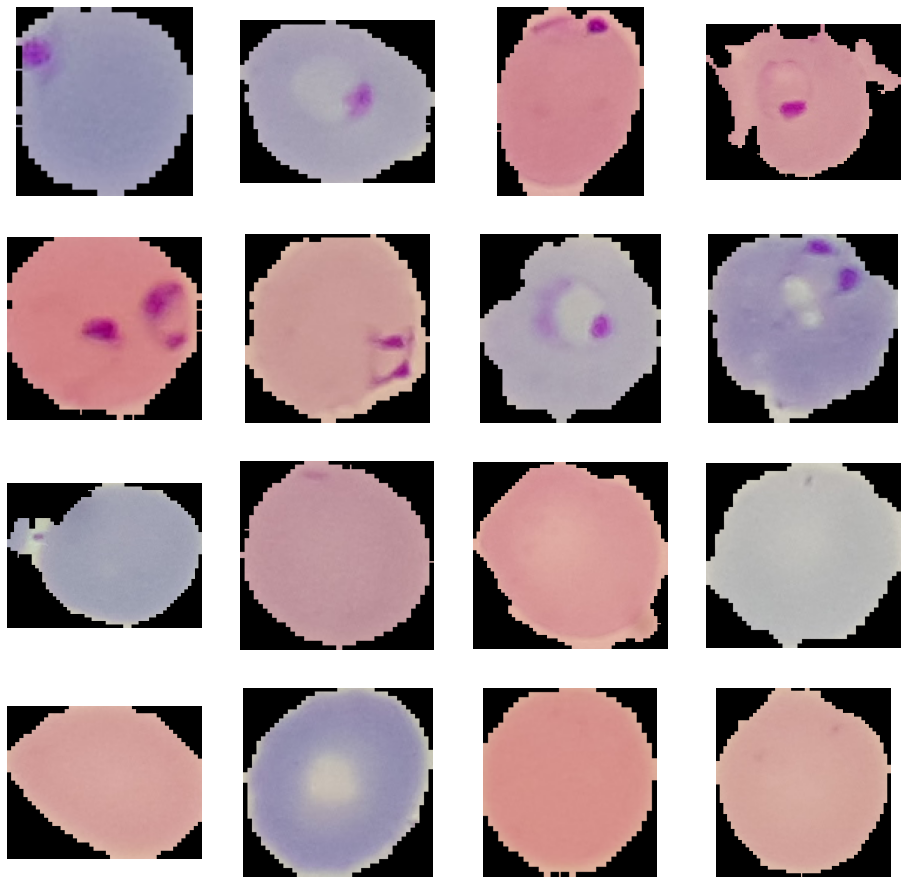

In [14]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_infected_pix = [os.path.join(TRAINING_INFECTED_DIR, 
fname) for fname in train_infected_names[pic_index-8:pic_index]]


next_uninfected_pix = [os.path.join(TRAINING_UNINFECTED_DIR, fname) for fname in train_uninfected_names[pic_index-8:pic_index]]


for i, img_path in enumerate(next_infected_pix+next_uninfected_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

**Connect Google Colab to Drive**

In [15]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate


In [17]:
from google.colab import auth
auth.authenticate_user()

from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL

vcode = getpass.getpass()

!echo {vcode} | google-drive-ocamlfuse -headless-id={creds.client_id} -secret={creds.client_secret}

··········
google-drive-ocamlfuse: unknown option '-headless-id=32555940559.apps.googleusercontent.com'.
Usage: google-drive-ocamlfuse [options] [mountpoint]
  -version             show version and exit.
  -verbose             enable verbose logging on stdout. Default is false.
  -debug               enable debug mode (implies -verbose, -f). Default is false.
  -label               use a specific label to identify the filesystem. Default is "default".
  -id                  provide OAuth2 client ID.
  -secret              provide OAuth2 client secret.
  -f                   keep the process in foreground.
  -d                   enable FUSE debug output (implies -f).
  -m                   run in multi-threaded mode (default).
  -s                   run in single-threaded mode.
  -o                   specify FUSE mount options.
  -cc                  clear cache
  -headless            enable headless mode. Default is false.
  -skiptrash           enable permanent deletion mode. Default 

In [18]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

training_directory = '/content/cell-images-for-detecting-malaria/cell_images/training/'
train_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        training_directory,
        target_size=(80, 80),
        batch_size=256,
        class_mode='binary')

Found 27525 images belonging to 2 classes.


In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(80, 80, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class (uninfected) and 0 class (infected)
    tf.keras.layers.Dense(1, activation='sigmoid')
]
)

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [22]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [23]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  
      epochs=15,
      verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
100/100 [==============================] - 139s 1s/step - loss: 0.6327 - acc: 0.6406
Epoch 2/15
100/100 [==============================] - 137s 1s/step - loss: 0.3037 - acc: 0.8774
Epoch 3/15
100/100 [==============================] - 136s 1s/step - loss: 0.1811 - acc: 0.9388
Epoch 4/15
100/100 [==============================] - 135s 1s/step - loss: 0.1674 - acc: 0.9463
Epoch 5/15
100/100 [==============================] - 136s 1s/step - loss: 0.1491 - acc: 0.9524
Epoch 6/15
100/100 [==============================] - 136s 1s/step - loss: 0.1379 - acc: 0.9543
Epoch 7/15
100/100 [==============================] - 137s 1s/step - loss: 0.1298 - acc: 0.9571
Epoch 8/15
100/100 [==============================] - 136s 1s/step - loss: 0.1222 - acc: 0.9586
Epoch 9/15
100/100 [==============================] - 136s 1s/step - loss: 0.1143 - acc: 0.9607
Epoch 10/15
100/100 [==============================] - 136s 

**Visualize Accuracy and Loss**

<Figure size 432x288 with 0 Axes>

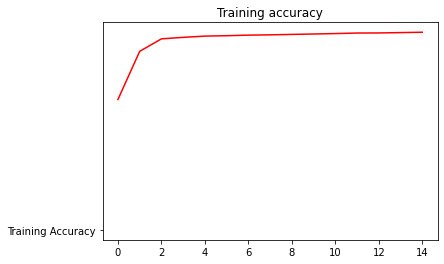

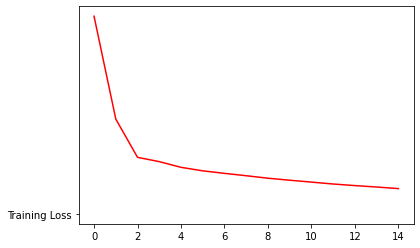

<Figure size 432x288 with 0 Axes>

In [26]:
%matplotlib inline
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------

acc=history.history['acc']
loss=history.history['loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.title('Training accuracy')
plt.figure()

#------------------------------------------------
# Plot training loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.figure()

**Predict on test data**

In [28]:
testing_directory = '/content/cell-images-for-detecting-malaria/cell_images/testing/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        testing_directory,
        target_size=(80, 80),
        color_mode="rgb",
        shuffle = False,
        class_mode='binary',
        batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = nb_samples, verbose=1)

Found 7423 images belonging to 2 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
7423/7423 [==============================] - 38s 5ms/step


In [29]:
loss, acc = model.evaluate_generator(test_generator, steps=nb_samples)

Instructions for updating:
Please use Model.evaluate, which supports generators.


In [30]:
loss

0.06614889949560165

In [31]:
acc

0.978175938129425

We can see that our accuracy on the test dataset is around 97 percent which is pretty good. It can be improved further